In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Dropout, Reshape, LeakyReLU, Conv2DTranspose
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

# Install required packages
!pip install opendatasets tqdm opencv-python --quiet

In [ ]:

import opendatasets as od
import os
import cv2
from tqdm import tqdm
from PIL import Image, ImageChops, ImageEnhance

# Create directory for generated images
os.makedirs('/content/generated_images', exist_ok=True)

# Set random seed for reproducibility
np.random.seed(2)
tf.random.set_seed(2)

# Set parameters - REDUCED FOR FASTER EXECUTION
latent_dim = 100
image_size = (128, 128)
batch_size = 32
MAX_SAMPLES_PER_CLASS = 3000  # Reduced from 1000
GAN_EPOCHS = 40  # Reduced from 50
CNN_EPOCHS = 8   # Reduced from 10
GENERATED_IMAGES = 1500  # Reduced from 500

In [ ]:

# Download dataset
dataset_url = "https://www.kaggle.com/sophatvathana/casia-dataset"
od.download(dataset_url)


Skipping, found downloaded files in "./casia-dataset" (use force=True to force download)


In [ ]:
# Function to convert to ELA image
def convert_to_ela_image(path, quality):
    temp_filename = 'temp_file_name.jpg'

    try:
        image = Image.open(path).convert('RGB')
        image.save(temp_filename, 'JPEG', quality=quality)
        temp_image = Image.open(temp_filename)

        ela_image = ImageChops.difference(image, temp_image)

        extrema = ela_image.getextrema()
        max_diff = max([ex[1] for ex in extrema])
        if max_diff == 0:
            max_diff = 1
        scale = 255.0 / max_diff

        ela_image = ImageEnhance.Brightness(ela_image).enhance(scale)

        return ela_image
    except Exception as e:
        print(f"Error processing {path}: {e}")
        return None
    finally:
        # Clean up temp file if it exists
        if os.path.exists(temp_filename):
            os.remove(temp_filename)

In [ ]:
# Load data with a smaller sample size
def load_data(max_samples_per_class=MAX_SAMPLES_PER_CLASS):
    X = []  # ELA converted images
    Y = []  # 0 for fake, 1 for real

    # Process real images
    print("Processing real images...")
    path = '/content/casia-dataset/CASIA2/Au/'
    count = 0
    for dirname, _, filenames in os.walk(path):
        for filename in tqdm(filenames):
            if count >= max_samples_per_class:
                break
            if filename.lower().endswith(('jpg', 'jpeg', 'png')):
                try:
                    full_path = os.path.join(dirname, filename)
                    ela_img = convert_to_ela_image(full_path, 90)
                    if ela_img is not None:
                        img_array = np.array(ela_img.resize(image_size)) / 255.0
                        X.append(img_array)
                        Y.append(1)
                        count += 1
                except Exception as e:
                    print(f"Error processing {filename}: {e}")

    real_count = count
    print(f"Processed {real_count} real images")

    # Process fake images
    print("Processing fake images...")
    path = '/content/casia-dataset/CASIA2/Tp/'
    count = 0
    for dirname, _, filenames in os.walk(path):
        for filename in tqdm(filenames):
            if count >= max_samples_per_class:
                break
            if filename.lower().endswith(('jpg', 'jpeg', 'png')):
                try:
                    full_path = os.path.join(dirname, filename)
                    ela_img = convert_to_ela_image(full_path, 90)
                    if ela_img is not None:
                        img_array = np.array(ela_img.resize(image_size)) / 255.0
                        X.append(img_array)
                        Y.append(0)
                        count += 1
                except Exception as e:
                    print(f"Error processing {filename}: {e}")

    fake_count = count
    print(f"Processed {fake_count} fake images")
    print(f"Total processed: {real_count + fake_count} images")

    # Convert to numpy arrays
    X = np.array(X)
    Y = to_categorical(Y, 2)

    # Split the data
    X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=5)
    print(f"Training set: {X_train.shape}, Validation set: {X_val.shape}")

    return X_train, X_val, Y_train, Y_val

In [ ]:
# Generator model
def build_generator():
    model = Sequential([
        # Foundation layer
        Dense(128 * 16 * 16, activation="relu", input_dim=latent_dim),
        Reshape((16, 16, 128)),

        # Upsampling layers
        Conv2DTranspose(128, kernel_size=4, strides=2, padding="same"),
        BatchNormalization(),
        LeakyReLU(0.2),

        Conv2DTranspose(64, kernel_size=4, strides=2, padding="same"),
        BatchNormalization(),
        LeakyReLU(0.2),

        # Output layer
        Conv2DTranspose(3, kernel_size=4, strides=2, padding="same", activation='tanh')
    ])
    return model

In [ ]:
# Discriminator model
def build_discriminator():
    model = Sequential([
        Conv2D(64, kernel_size=4, strides=2, input_shape=(128, 128, 3), padding="same"),
        LeakyReLU(0.2),

        Conv2D(128, kernel_size=4, strides=2, padding="same"),
        LeakyReLU(0.2),

        Flatten(),
        Dense(1, activation='sigmoid')
    ])
    return model

In [ ]:
# Train GAN with fewer epochs
def train_gan(generator, discriminator, X_train, epochs=GAN_EPOCHS, batch_size=32):
    # Compile discriminator
    discriminator.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy')

    # Compile generator in GAN model
    discriminator.trainable = False
    gan_input = Input(shape=(latent_dim,))
    gan_output = discriminator(generator(gan_input))
    gan = Model(gan_input, gan_output)
    gan.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy')

    # Train with progress bar
    print(f"Training GAN for {epochs} epochs...")
    for epoch in tqdm(range(epochs)):
        # Train discriminator
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        real_imgs = X_train[idx]

        noise = np.random.normal(0, 1, (batch_size, latent_dim))
        fake_imgs = generator.predict(noise, verbose=0)

        d_loss_real = discriminator.train_on_batch(real_imgs, np.ones((batch_size, 1)))
        d_loss_fake = discriminator.train_on_batch(fake_imgs, np.zeros((batch_size, 1)))
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        # Train generator
        noise = np.random.normal(0, 1, (batch_size, latent_dim))
        g_loss = gan.train_on_batch(noise, np.ones((batch_size, 1)))

        # Print progress occasionally
        if epoch % 5 == 0:
            print(f"Epoch {epoch}/{epochs} [D loss: {d_loss:.4f}] [G loss: {g_loss:.4f}]")

    return generator, discriminator

In [ ]:
# Generate smaller number of images
def generate_fake_images(generator, count=GENERATED_IMAGES):
    print(f"Generating {count} fake images...")
    noise = np.random.normal(0, 1, (count, latent_dim))
    generated_images = generator.predict(noise, verbose=1)
    # Scale from [-1,1] to [0,1]
    generated_images = 0.5 * generated_images + 0.5

    # Save a sample of the generated images
    sample_size = min(16, count)
    plt.figure(figsize=(10, 10))
    for i in range(sample_size):
        plt.subplot(4, 4, i+1)
        plt.imshow(generated_images[i])
        plt.axis('off')
    plt.tight_layout()
    plt.savefig('/content/generated_images/sample_grid.png')
    plt.close()

    return generated_images

# Define simpler CNN model for faster training
def build_forgery_detection_model():
    model = Sequential([
        # First block
        Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(128, 128, 3)),
        MaxPooling2D(2, 2),

        # Second block
        Conv2D(64, (3, 3), padding='same', activation='relu'),
        MaxPooling2D(2, 2),

        # Third block
        Conv2D(128, (3, 3), padding='same', activation='relu'),
        MaxPooling2D(2, 2),

        # Output layers
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(2, activation='softmax')
    ])

    model.compile(
        optimizer=Adam(learning_rate=0.0001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

In [ ]:
# Evaluate model on a smaller subset of images
def evaluate_model(model, image_folder, label, max_images=100):
    images = []
    true_labels = []

    print(f"Evaluating on {image_folder} (max {max_images} images)...")

    # Get image files
    all_files = []
    for root, _, files in os.walk(image_folder):
        for file in files:
            if file.lower().endswith(('.jpg', '.jpeg', '.png')):
                all_files.append(os.path.join(root, file))

    # Limit the number of files
    if len(all_files) > max_images:
        import random
        random.shuffle(all_files)
        all_files = all_files[:max_images]

    # Process images
    for file_path in tqdm(all_files):
        try:
            img = cv2.imread(file_path)
            img = cv2.resize(img, image_size)
            img = img.astype("float32") / 255.0
            images.append(img)
            true_labels.append(label)
        except Exception as e:
            print(f"Error processing {file_path}: {e}")

    if not images:
        return 0, 0, 0.0

    # Make predictions
    images = np.array(images)
    true_labels = np.array(true_labels)
    predictions = model.predict(images, verbose=1)
    predicted_classes = np.argmax(predictions, axis=1)

    # Calculate accuracy
    correct = np.sum(predicted_classes == true_labels)
    total = len(true_labels)
    accuracy = (correct / total) * 100
    return correct, total, accuracy

Processing real images...


 40%|████      | 3020/7492 [00:39<00:58, 76.60it/s]


Processed 3000 real images
Processing fake images...


100%|██████████| 5124/5124 [00:35<00:00, 145.97it/s]


Processed 2064 fake images
Total processed: 5064 images
Training set: (4051, 128, 128, 3), Validation set: (1013, 128, 128, 3)
Building GAN models...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Training GAN...
Training GAN for 40 epochs...


  0%|          | 0/40 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py:82: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")
  2%|▎         | 1/40 [00:05<03:16,  5.03s/it]

Epoch 0/40 [D loss: 0.6929] [G loss: 0.7295]


 15%|█▌        | 6/40 [00:18<01:36,  2.83s/it]

Epoch 5/40 [D loss: 0.6931] [G loss: 0.6371]


 28%|██▊       | 11/40 [00:32<01:18,  2.69s/it]

Epoch 10/40 [D loss: 0.6939] [G loss: 0.5683]


 40%|████      | 16/40 [00:46<01:05,  2.71s/it]

Epoch 15/40 [D loss: 0.6947] [G loss: 0.5135]


 52%|█████▎    | 21/40 [00:59<00:50,  2.68s/it]

Epoch 20/40 [D loss: 0.6956] [G loss: 0.4711]


 65%|██████▌   | 26/40 [01:13<00:36,  2.60s/it]

Epoch 25/40 [D loss: 0.6964] [G loss: 0.4374]


 78%|███████▊  | 31/40 [01:26<00:24,  2.68s/it]

Epoch 30/40 [D loss: 0.6973] [G loss: 0.4088]


 90%|█████████ | 36/40 [01:50<00:14,  3.67s/it]

Epoch 35/40 [D loss: 0.6982] [G loss: 0.3848]


100%|██████████| 40/40 [02:01<00:00,  3.03s/it]


Generating 1500 fake images...
47/47 ━━━━━━━━━━━━━━━━━━━━ 16s 346ms/step
Augmenting training data with generated images...
Building and training CNN model...
Training with original data (baseline)...
Epoch 1/8
127/127 ━━━━━━━━━━━━━━━━━━━━ 146s 1s/step - accuracy: 0.6042 - loss: 0.5966 - val_accuracy: 0.8529 - val_loss: 0.3806
Epoch 2/8
127/127 ━━━━━━━━━━━━━━━━━━━━ 145s 1s/step - accuracy: 0.8806 - loss: 0.3380 - val_accuracy: 0.8806 - val_loss: 0.3341
Epoch 3/8
127/127 ━━━━━━━━━━━━━━━━━━━━ 203s 1s/step - accuracy: 0.8919 - loss: 0.2974 - val_accuracy: 0.8835 - val_loss: 0.3156
Epoch 4/8
127/127 ━━━━━━━━━━━━━━━━━━━━ 208s 1s/step - accuracy: 0.9022 - loss: 0.2932 - val_accuracy: 0.8855 - val_loss: 0.3049
Epoch 5/8
127/127 ━━━━━━━━━━━━━━━━━━━━ 197s 1s/step - accuracy: 0.8945 - loss: 0.2855 - val_accuracy: 0.8865 - val_loss: 0.2998
Epoch 6/8
127/127 ━━━━━━━━━━━━━━━━━━━━ 203s 1s/step - accuracy: 0.9027 - loss: 0.2756 - val_accuracy: 0.8875 - val_loss: 0.2946
Epoch 7/8
127/127 ━━━━━━━━━━━━━━

100%|██████████| 100/100 [00:00<00:00, 338.13it/s]


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 240ms/step
Evaluating on /content/casia-dataset/CASIA2/Au/ (max 100 images)...


100%|██████████| 100/100 [00:00<00:00, 350.30it/s]


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 214ms/step
Baseline - Fake Images Accuracy: 0.00% (0/100)
Baseline - Real Images Accuracy: 100.00% (100/100)

Training with GAN-augmented data...
Epoch 1/8
174/174 ━━━━━━━━━━━━━━━━━━━━ 199s 1s/step - accuracy: 0.6844 - loss: 0.4855 - val_accuracy: 0.8717 - val_loss: 0.3503
Epoch 2/8
174/174 ━━━━━━━━━━━━━━━━━━━━ 200s 1s/step - accuracy: 0.9081 - loss: 0.2521 - val_accuracy: 0.8796 - val_loss: 0.3212
Epoch 3/8
174/174 ━━━━━━━━━━━━━━━━━━━━ 207s 1s/step - accuracy: 0.9085 - loss: 0.2466 - val_accuracy: 0.8687 - val_loss: 0.3309
Epoch 4/8
174/174 ━━━━━━━━━━━━━━━━━━━━ 198s 1s/step - accuracy: 0.9114 - loss: 0.2432 - val_accuracy: 0.8628 - val_loss: 0.3371
Epoch 5/8
174/174 ━━━━━━━━━━━━━━━━━━━━ 193s 1s/step - accuracy: 0.9123 - loss: 0.2348 - val_accuracy: 0.8638 - val_loss: 0.3280
Epoch 6/8
174/174 ━━━━━━━━━━━━━━━━━━━━ 195s 1s/step - accuracy: 0.9134 - loss: 0.2292 - val_accuracy: 0.8687 - val_loss: 0.3088
Epoch 7/8
174/174 ━━━━━━━━━━━━━━━━━━━━ 204s 1s/step - accu

100%|██████████| 100/100 [00:00<00:00, 489.18it/s]


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 285ms/step
Evaluating on /content/casia-dataset/CASIA2/Au/ (max 100 images)...


100%|██████████| 100/100 [00:00<00:00, 335.29it/s]


4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 340ms/step
Augmented - Fake Images Accuracy: 9.00% (9/100)
Augmented - Real Images Accuracy: 94.00% (94/100)

--- COMPARISON OF RESULTS ---
Baseline model average accuracy: 50.00%
Augmented model average accuracy: 51.50%
Improvement: 1.50%


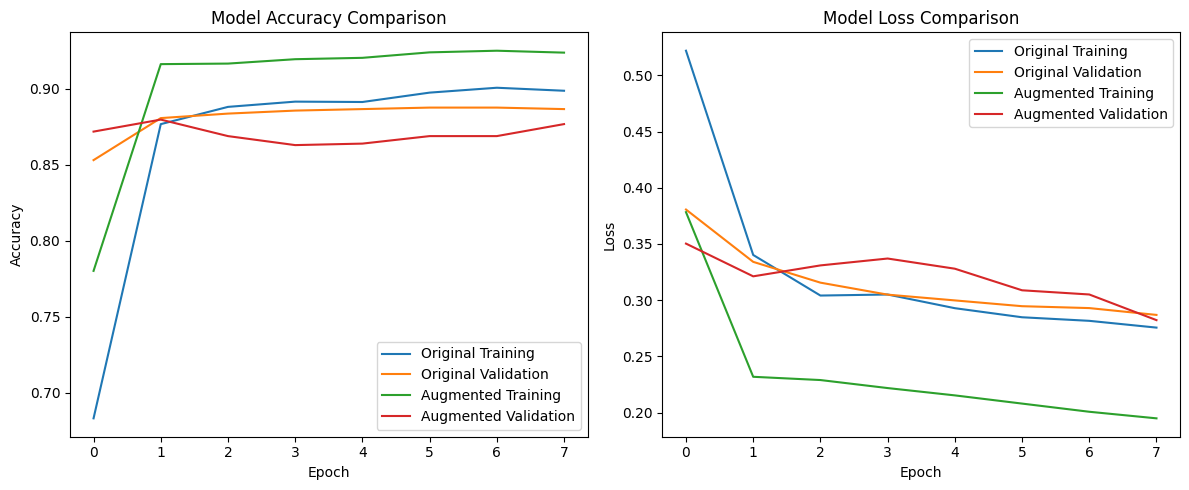


Complete! Results saved as /content/training_comparison.png


In [ ]:
# Constants (define at the top of your script)
MAX_SAMPLES_PER_CLASS = 3000
GAN_EPOCHS = 40
CNN_EPOCHS = 8
GENERATED_IMAGES = 1500

# Main function
def main():
    # Load data with increased sample size
    X_train, X_val, Y_train, Y_val = load_data(max_samples_per_class=MAX_SAMPLES_PER_CLASS)

    # Build and train GAN
    print("Building GAN models...")
    generator = build_generator()
    discriminator = build_discriminator()

    print("Training GAN...")
    generator, discriminator = train_gan(generator, discriminator, X_train, epochs=GAN_EPOCHS)

    # Generate fake images for augmenting the dataset
    fake_images = generate_fake_images(generator, count=GENERATED_IMAGES)

    # Create labels for fake images (class 0 in one-hot [1, 0])
    fake_labels = np.zeros((fake_images.shape[0], 2))
    fake_labels[:, 0] = 1

    # Combine original and generated images for augmented training
    print("Augmenting training data with generated images...")
    augmented_X_train = np.concatenate([X_train, fake_images], axis=0)
    augmented_Y_train = np.concatenate([Y_train, fake_labels], axis=0)

    # Build CNN model (baseline)
    print("Building and training CNN model...")
    cnn_model = build_forgery_detection_model()

    print("Training with original data (baseline)...")
    history_original = cnn_model.fit(
        X_train, Y_train,
        validation_data=(X_val, Y_val),
        epochs=CNN_EPOCHS,
        batch_size=32,
        verbose=1
    )

    # Evaluate baseline model
    print("\n--- BASELINE MODEL EVALUATION (TRAINED WITHOUT AUGMENTATION) ---")
    fake_folder = '/content/casia-dataset/CASIA2/Tp/'
    real_folder = '/content/casia-dataset/CASIA2/Au/'

    correct_fake, total_fake, acc_fake = evaluate_model(cnn_model, fake_folder, label=0, max_images=100)
    correct_real, total_real, acc_real = evaluate_model(cnn_model, real_folder, label=1, max_images=100)

    print(f"Baseline - Fake Images Accuracy: {acc_fake:.2f}% ({correct_fake}/{total_fake})")
    print(f"Baseline - Real Images Accuracy: {acc_real:.2f}% ({correct_real}/{total_real})")

    # Train with augmented data
    print("\nTraining with GAN-augmented data...")
    cnn_model_augmented = build_forgery_detection_model()

    history_augmented = cnn_model_augmented.fit(
        augmented_X_train, augmented_Y_train,
        validation_data=(X_val, Y_val),
        epochs=CNN_EPOCHS,
        batch_size=32,
        verbose=1
    )

    # Evaluate augmented model
    print("\n--- AUGMENTED MODEL EVALUATION (TRAINED WITH GAN AUGMENTATION) ---")
    correct_fake_aug, total_fake_aug, acc_fake_aug = evaluate_model(cnn_model_augmented, fake_folder, label=0, max_images=100)
    correct_real_aug, total_real_aug, acc_real_aug = evaluate_model(cnn_model_augmented, real_folder, label=1, max_images=100)

    print(f"Augmented - Fake Images Accuracy: {acc_fake_aug:.2f}% ({correct_fake_aug}/{total_fake_aug})")
    print(f"Augmented - Real Images Accuracy: {acc_real_aug:.2f}% ({correct_real_aug}/{total_real_aug})")

    # Compare results
    print("\n--- COMPARISON OF RESULTS ---")
    print(f"Baseline model average accuracy: {(acc_fake + acc_real)/2:.2f}%")
    print(f"Augmented model average accuracy: {(acc_fake_aug + acc_real_aug)/2:.2f}%")
    print(f"Improvement: {((acc_fake_aug + acc_real_aug) - (acc_fake + acc_real))/2:.2f}%")

    # Plot training history comparison
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history_original.history['accuracy'], label='Original Training')
    plt.plot(history_original.history['val_accuracy'], label='Original Validation')
    plt.plot(history_augmented.history['accuracy'], label='Augmented Training')
    plt.plot(history_augmented.history['val_accuracy'], label='Augmented Validation')
    plt.title('Model Accuracy Comparison')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history_original.history['loss'], label='Original Training')
    plt.plot(history_original.history['val_loss'], label='Original Validation')
    plt.plot(history_augmented.history['loss'], label='Augmented Training')
    plt.plot(history_augmented.history['val_loss'], label='Augmented Validation')
    plt.title('Model Loss Comparison')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()

    plt.tight_layout()
    plt.savefig('/content/training_comparison.png')
    plt.show()

    print("\nComplete! Results saved as /content/training_comparison.png")

if __name__ == "__main__":
    main()